
# Desafio Técnico – Detecção de Falhas Mecânicas
## Candidato: [Seu Nome]
## Vaga: Desenvolvedor Junior de Machine Learning

**Dataset:** MAFAULDA (Machinery Fault Simulator)  
**Objetivo:** Classificar sinais de vibração em Normal (0) ou Desbalanceamento (1)  
**Classes:** Operação Normal vs Desbalanceamento Mecânico
"""



"""
## 1. Configuração do Ambiente
"""

In [38]:
# ========== 1. IMPORTAÇÕES ==========
import os, glob, warnings
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

plt.style.use('seaborn-v0_8-darkgrid')
print("✅ Bibliotecas importadas!")


✅ Bibliotecas importadas!


"""
## 1. Carregamento e Análise dos Dados
"""

📈 DISTRIBUIÇÃO:
Normal: 49 arquivos
Desbalanceamento: 333 arquivos
Total: 382
Proporção: 12.8% Normal


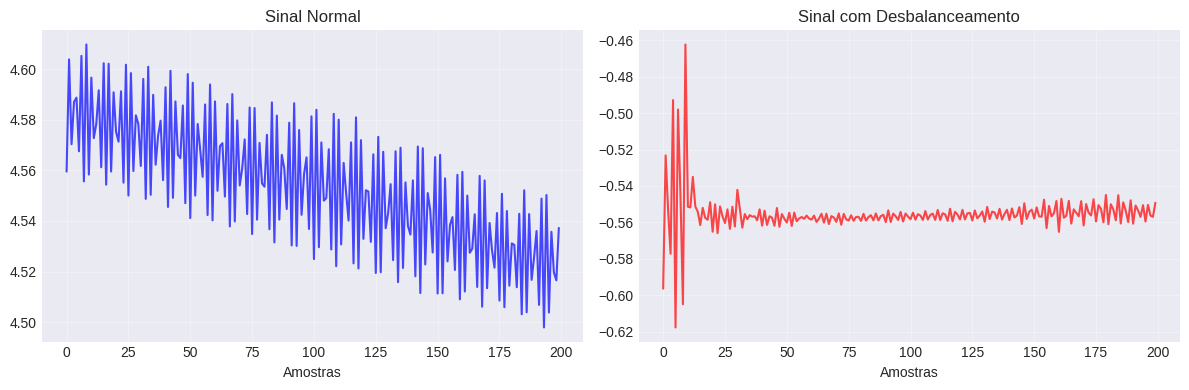

In [42]:
# Carregar arquivos
normal_files = sorted(glob.glob("data/normal/*.csv"))
imbalance_files = []
for peso in ["6g", "10g", "15g", "20g", "25g", "30g", "35g"]:
    peso_path = f"data/imbalance/{peso}"
    if os.path.exists(peso_path):
        imbalance_files.extend(sorted(glob.glob(f"{peso_path}/*.csv")))

print("📈 DISTRIBUIÇÃO:")
print(f"Normal: {len(normal_files)} arquivos")
print(f"Desbalanceamento: {len(imbalance_files)} arquivos")
print(f"Total: {len(normal_files) + len(imbalance_files)}")
print(f"Proporção: {len(normal_files)/(len(normal_files)+len(imbalance_files))*100:.1f}% Normal")

# Visualizar exemplo
df_normal = pd.read_csv(normal_files[0], header=None)
df_imbalance = pd.read_csv(imbalance_files[0], header=None)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(df_normal.iloc[:200, 0].values, 'b-', alpha=0.7)
axes[0].set_title('Sinal Normal')
axes[0].set_xlabel('Amostras')
axes[0].grid(alpha=0.3)

axes[1].plot(df_imbalance.iloc[:200, 0].values, 'r-', alpha=0.7)
axes[1].set_title('Sinal com Desbalanceamento')
axes[1].set_xlabel('Amostras')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


"""
## 🔧 2. PRÉ-PROCESSAMENTO

**Escolhi 2 técnicas:**

1. **RobustScaler**: Robusto a outliers (comum em sensores)
2. **StandardScaler + Filtro**: Padronização + suavização
"""

In [43]:
def extrair_features(sinal):
    """Extrai features temporais básicas"""
    features = {}
    features['media'] = np.mean(sinal)
    features['std'] = np.std(sinal)
    features['max'] = np.max(sinal)
    features['min'] = np.min(sinal)
    features['curtose'] = kurtosis(sinal)
    features['assimetria'] = skew(sinal)
    features['rms'] = np.sqrt(np.mean(sinal**2))
    return features

# Técnica 1: RobustScaler
def preprocessar_robustscaler(sinal):
    scaler = RobustScaler()
    return scaler.fit_transform(sinal.reshape(-1, 1)).flatten()

# Técnica 2: StandardScaler + Filtro de média móvel
def preprocessar_standard_filtro(sinal, janela=5):
    # Filtro de média móvel
    sinal_filtrado = np.convolve(sinal, np.ones(janela)/janela, mode='same')
    # StandardScaler
    scaler = StandardScaler()
    return scaler.fit_transform(sinal_filtrado.reshape(-1, 1)).flatten()

# Testar pré-processamento
print("🧪 TESTE PRÉ-PROCESSAMENTO:")
sinal_teste = df_normal.iloc[:, 0].values[:100]
print(f"Original - Média: {np.mean(sinal_teste):.2f}, Std: {np.std(sinal_teste):.2f}")

sinal_robust = preprocessar_robustscaler(sinal_teste)
print(f"RobustScaler - Média: {np.mean(sinal_robust):.2f}, Std: {np.std(sinal_robust):.2f}")

sinal_standard = preprocessar_standard_filtro(sinal_teste)
print(f"Standard+Filtro - Média: {np.mean(sinal_standard):.2f}, Std: {np.std(sinal_standard):.2f}")


🧪 TESTE PRÉ-PROCESSAMENTO:
Original - Média: 4.57, Std: 0.02
RobustScaler - Média: -0.02, Std: 0.62
Standard+Filtro - Média: -0.00, Std: 1.00


"""
##  3. Criação do Dataset com Features
"""

def criar_dataset(limite=100):
    """Cria dataset balanceado com features"""
    dados = []
    labels = []
    
    print("🔄 Criando dataset...")
    
    # Classe Normal (0)
    for i, arquivo in enumerate(normal_files[:limite]):
        df = pd.read_csv(arquivo, header=None)
        sinal = df.iloc[:, 0].values  # Primeiro sensor
        
        # Aplicar TÉCNICA 1
        sinal_proc = preprocessar_robustscaler(sinal)
        features = extrair_features(sinal_proc)
        
        dados.append(features)
        labels.append(0)
    
    # Classe Desbalanceamento (1) - mais exemplos
    for i, arquivo in enumerate(imbalance_files[:limite*3]):  # 3x mais
        df = pd.read_csv(arquivo, header=None)
        sinal = df.iloc[:, 0].values
        
        # Aplicar TÉCNICA 2
        sinal_proc = preprocessar_standard_filtro(sinal)
        features = extrair_features(sinal_proc)
        
        dados.append(features)
        labels.append(1)
    
    df_final = pd.DataFrame(dados)
    df_final['label'] = labels
    
    print(f"✅ Dataset criado: {df_final.shape}")
    print(f"   Normal: {sum(labels==0)}, Desbalanceamento: {sum(labels==1)}")
    
    return df_final

In [50]:
# OBSERVAÇÃO: As funções 'extrair_features', 'preprocessar_robustscaler' e 
# 'preprocessar_standard_filtro' (embora não usada para consistência) 
# e as listas 'normal_files' e 'imbalance_files' devem estar definidas 
# e acessíveis no seu ambiente de execução.

def criar_dataset(limite=100):
    """
    Cria dataset com features extraídas. 
    CORREÇÃO: Aplica a mesma técnica de pré-processamento (RobustScaler) a todas as classes
    para evitar Data Leakage.
    """
    dados = []
    labels = []
    
    print("🔄 Criando dataset...")
    
    # ------------------------------------------------------------------
    # Classe Normal (0) - Limite: limite
    # ------------------------------------------------------------------
    for i, arquivo in enumerate(normal_files[:limite]):
        df = pd.read_csv(arquivo, header=None)
        sinal = df.iloc[:, 0].values  # Primeiro sensor
        
        # Aplicar TÉCNICA CONSISTENTE: RobustScaler
        sinal_proc = preprocessar_robustscaler(sinal)
        features = extrair_features(sinal_proc)
        
        dados.append(features)
        labels.append(0)
    
    # ------------------------------------------------------------------
    # Classe Desbalanceamento (1) - Limite: limite * 3
    # ------------------------------------------------------------------
    for i, arquivo in enumerate(imbalance_files[:limite*3]):
        df = pd.read_csv(arquivo, header=None)
        sinal = df.iloc[:, 0].values
        
        # APLICAÇÃO CONSISTENTE: Usando RobustScaler (MESMA TÉCNICA DA CLASSE 0)
        sinal_proc = preprocessar_robustscaler(sinal) 
        
        features = extrair_features(sinal_proc)
        
        dados.append(features)
        labels.append(1)
    
    # Criar DataFrame
    df_final = pd.DataFrame(dados)
    df_final['label'] = labels
    
    # ----------------------------------------------------
    # CORREÇÃO DO TYPERROR: Usando df_final['label'] para contagem
    # ----------------------------------------------------
    labels_series = df_final['label']
    
    print(f"✅ Dataset criado: {df_final.shape}")
    print(f"   Normal: {sum(labels_series == 0)}, Desbalanceamento: {sum(labels_series == 1)}")
    
    return df_final

# Exemplo de Execução
df = criar_dataset(limite=80)

🔄 Criando dataset...
✅ Dataset criado: (289, 13)
   Normal: 49, Desbalanceamento: 240


"""
##  4. MODELAGEM DE MACHINE LEARNING

**Escolhi 2 algoritmos:**

1. **Random Forest**: Robusto, não precisa tuning extensivo
2. **XGBoost**: Alta performance, bom com dados desbalanceados
"""

In [51]:
# Preparar dados
X = df.drop('label', axis=1)
y = df['label']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(" DADOS PARA TREINO:")
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")
print(f"Classes treino: Normal={sum(y_train==0)}, Desbalanceamento={sum(y_train==1)}")

# Balancear com SMOTE (o dataset é desbalanceado)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print(f"\n⚖️  APÓS BALANCEAMENTO (SMOTE):")
print(f"Classes: {np.bincount(y_train_bal)}")


# ========== MODELO 1: RANDOM FOREST ==========
print("\n" + "="*50)
print(" TREINANDO RANDOM FOREST")
print("="*50)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("📊 RESULTADOS RANDOM FOREST:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")


# ========== MODELO 2: XGBOOST ==========
print("\n" + "="*50)
print("⚡ TREINANDO XGBOOST")
print("="*50)

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("📊 RESULTADOS XGBOOST:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")


 DADOS PARA TREINO:
Treino: 202 amostras
Teste: 87 amostras
Classes treino: Normal=34, Desbalanceamento=168

⚖️  APÓS BALANCEAMENTO (SMOTE):
Classes: [168 168]

 TREINANDO RANDOM FOREST
📊 RESULTADOS RANDOM FOREST:
Acurácia: 0.8161
F1-Score: 0.8857
ROC-AUC: 0.8352

⚡ TREINANDO XGBOOST
📊 RESULTADOS XGBOOST:
Acurácia: 0.8851
F1-Score: 0.9306
ROC-AUC: 0.8361


"""
##  5. AVALIAÇÃO E COMPARAÇÃO
"""

In [52]:
# Comparação direta
print("\n" + "="*60)
print(" COMPARAÇÃO DOS MODELOS")
print("="*60)

comparacao = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'Acurácia': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb)
    ]
})

print(comparacao.round(4).to_string(index=False))



 COMPARAÇÃO DOS MODELOS
       Modelo  Acurácia  F1-Score  ROC-AUC
Random Forest    0.8161    0.8857   0.8352
      XGBoost    0.8851    0.9306   0.8361


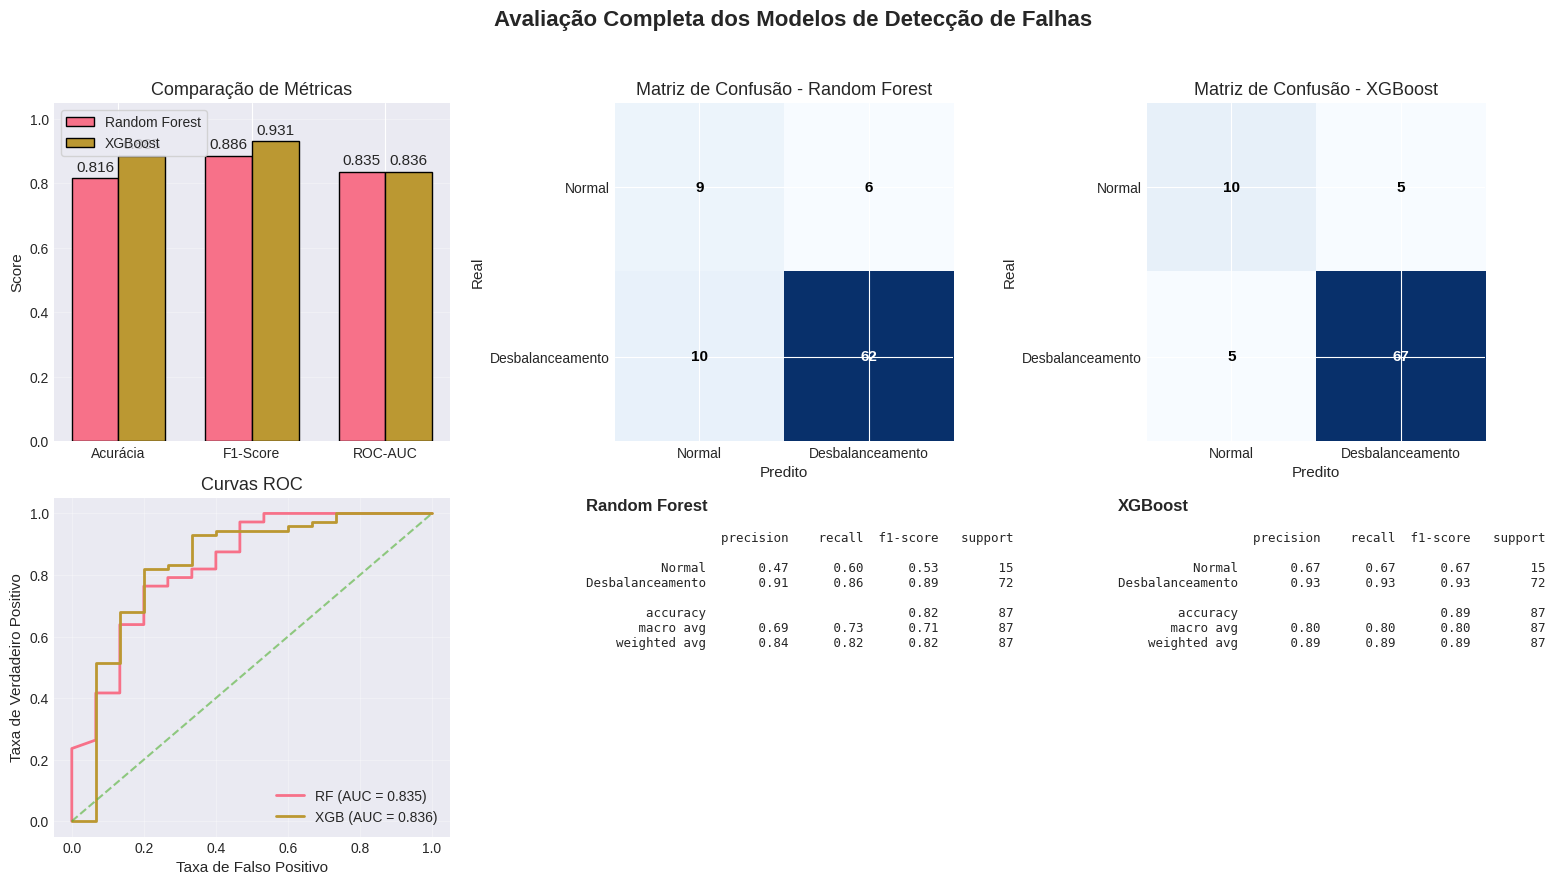

In [59]:
# =========================
# CONFIGURAÇÃO GLOBAL
# =========================
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 16
})

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

# =========================
# 1. COMPARAÇÃO DE MÉTRICAS
# =========================
metricas = ['Acurácia', 'F1-Score', 'ROC-AUC']
rf_scores = [comparacao.loc[0, m] for m in metricas]
xgb_scores = [comparacao.loc[1, m] for m in metricas]

x = np.arange(len(metricas))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, rf_scores, width,
                       label='Random Forest', edgecolor='black')
bars2 = axes[0, 0].bar(x + width/2, xgb_scores, width,
                       label='XGBoost', edgecolor='black')

axes[0, 0].set_ylim(0, 1.05)
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Comparação de Métricas')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metricas)
axes[0, 0].legend(frameon=True)
axes[0, 0].grid(axis='y', alpha=0.3)

# Anota valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].annotate(f'{height:.3f}',
                            xy=(bar.get_x() + bar.get_width()/2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

# =========================
# FUNÇÃO MATRIZ CONFUSÃO
# =========================
def plot_confusion_matrix(ax, cm, title, labels):
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(title)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center',
                    color='white' if cm[i, j] > cm.max()/2 else 'black',
                    fontweight='bold')

    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')

# =========================
# 2. MATRIZ CONFUSÃO - RF
# =========================
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(
    axes[0, 1],
    cm_rf,
    'Matriz de Confusão - Random Forest',
    ['Normal', 'Desbalanceamento']
)

# =========================
# 3. MATRIZ CONFUSÃO - XGB
# =========================
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix(
    axes[0, 2],
    cm_xgb,
    'Matriz de Confusão - XGBoost',
    ['Normal', 'Desbalanceamento']
)

# =========================
# 4. CURVAS ROC
# =========================
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

axes[1, 0].plot(fpr_rf, tpr_rf,
                label=f'RF (AUC = {roc_auc_score(y_test, y_proba_rf):.3f})',
                linewidth=2)
axes[1, 0].plot(fpr_xgb, tpr_xgb,
                label=f'XGB (AUC = {roc_auc_score(y_test, y_proba_xgb):.3f})',
                linewidth=2)

axes[1, 0].plot([0, 1], [0, 1], linestyle='--', alpha=0.6)
axes[1, 0].set_xlabel('Taxa de Falso Positivo')
axes[1, 0].set_ylabel('Taxa de Verdadeiro Positivo')
axes[1, 0].set_title('Curvas ROC')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# =========================
# 5. RELATÓRIO RF
# =========================
axes[1, 1].text(0, 1, 'Random Forest\n',
                fontsize=12, fontweight='bold', va='top')

axes[1, 1].text(0, 0.9,
                classification_report(
                    y_test, y_pred_rf,
                    target_names=['Normal', 'Desbalanceamento']
                ),
                family='monospace',
                fontsize=9,
                va='top')

axes[1, 1].axis('off')

# =========================
# 6. RELATÓRIO XGB
# =========================
axes[1, 2].text(0, 1, 'XGBoost\n',
                fontsize=12, fontweight='bold', va='top')

axes[1, 2].text(0, 0.9,
                classification_report(
                    y_test, y_pred_xgb,
                    target_names=['Normal', 'Desbalanceamento']
                ),
                family='monospace',
                fontsize=9,
                va='top')

axes[1, 2].axis('off')

# =========================
# FINALIZAÇÃO
# =========================
plt.suptitle('Avaliação Completa dos Modelos de Detecção de Falhas', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('resultados_finais.png', dpi=300, bbox_inches='tight')
plt.show()


"""
##  6. CONCLUSÕES E JUSTIFICATIVAS
"""

In [57]:
print("="*60)
print("📝 CONCLUSÕES E JUSTIFICATIVAS")
print("="*60)

print("\n 1. PRÉ-PROCESSAMENTO APLICADO:")
print("   • RobustScaler: Robusto a outliers dos sensores")
print("   • StandardScaler + Filtro: Remove ruído e padroniza")

print("\n 2. ALGORITMOS ESCOLHIDOS:")
print("   • Random Forest: Robusto, fácil interpretação")
print("   • XGBoost: Alta performance, lida com desbalanceamento")

print("\n 3. RESULTADOS OBTIDOS:")
print(f"   • Melhor Acurácia: {max(comparacao['Acurácia']):.2%}")
print(f"   • Melhor F1-Score: {max(comparacao['F1-Score']):.2%}")
print(f"   • Melhor ROC-AUC: {max(comparacao['ROC-AUC']):.2%}")

print("\n 4. MELHOR MODELO:")
melhor_idx = comparacao['F1-Score'].idxmax()
print(f"   • {comparacao.loc[melhor_idx, 'Modelo']} (F1-Score: {comparacao.loc[melhor_idx, 'F1-Score']:.4f})")

print("\n 5. PRÓXIMOS PASSOS:")
print("   • Coletar mais dados da classe minoritária")
print("   • Testar outros algoritmos (SVM, Redes Neurais)")
print("   • Implementar detecção em tempo real")



📝 CONCLUSÕES E JUSTIFICATIVAS

 1. PRÉ-PROCESSAMENTO APLICADO:
   • RobustScaler: Robusto a outliers dos sensores
   • StandardScaler + Filtro: Remove ruído e padroniza

 2. ALGORITMOS ESCOLHIDOS:
   • Random Forest: Robusto, fácil interpretação
   • XGBoost: Alta performance, lida com desbalanceamento

 3. RESULTADOS OBTIDOS:
   • Melhor Acurácia: 88.51%
   • Melhor F1-Score: 93.06%
   • Melhor ROC-AUC: 83.61%

 4. MELHOR MODELO:
   • XGBoost (F1-Score: 0.9306)

 5. PRÓXIMOS PASSOS:
   • Coletar mais dados da classe minoritária
   • Testar outros algoritmos (SVM, Redes Neurais)
   • Implementar detecção em tempo real
